# Lab 2: Building a Travel Planner with a Simple LangGraph

## Overview

This lab guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

#### What gets covered in this lab: 
we wil cover these aspects below:
- LangGraph constructs for how to build Agentic systems with Graph
- Introduction to short term and long term memory for 'turn-by-turn' conversations

## Intro to Agents

Agents are intelligent systems or components that utilize Large Language Models (LLMs) to perform tasks in a dynamic and autonomous manner. Here's a breakdown of the key concepts:

### What Are Agents?
1. Step-by-Step Thinking: Agents leverage LLMs to think and reason through problems in a structured way, often referred to as chain-of-thought reasoning. This allows them to plan, evaluate, and execute tasks effectively.
2. Access to Tools: Agents can utilize external tools (e.g., calculators, databases, APIs) to enhance their decision-making and problem-solving capabilities.
3. Access to Memory: Agents can store and retrieve context, enabling them to work on tasks over time, adapt to user interactions, and handle complex workflows.

**Key characteristics of AI agents include:**

**Perception:** The ability to gather information from their environment through sensors or data inputs.
**Decision-making:** Using AI algorithms to process information and determine the best course of action.
**Action:** The capability to execute decisions and interact with the environment or users.
**Learning:** The ability to improve performance over time through experience and feedback.
**Autonomy:** Operating independently to some degree, without constant human intervention.
**Goal-oriented:** Working towards specific objectives or tasks.

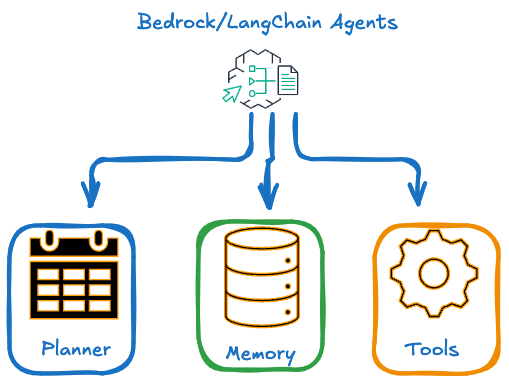

## Use Case Details

Our Travel Planner follows a straightforward, three-step process:

1. **Initial User Input**: 
   - The application prompts the user to enter their desired travel plan to get assistance from AI Agent.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [ ]:
# %pip install -U --no-cache-dir  \
# "langchain==0.3.7" \
# "langchain-aws==0.2.6" \
# "langchain-community==0.3.5" \
# "langchain-text-splitters==0.3.2" \
# "langchainhub==0.1.20" \
# "langgraph==0.2.45" \
# "langgraph-checkpoint==2.0.2" \
# "langgraph-sdk==0.1.35" \
# "langsmith==0.1.140" \
# "pypdf==3.8,<4" \
# "ipywidgets>=7,<8" \
# "matplotlib==3.9.0" \
# "faiss-cpu==1.8.0"

# %pip install -U --no-cache-dir transformers
# %pip install -U --no-cache-dir boto3
# %pip install grandalf==3.1.2

In [6]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
#load_dotenv()

## LangGraph Basics

### Key Components

1. **StateGraph**
   - This object will encapsulate the graph being traversed during excecution.
   - The core of our application, defining the flow of our Travel Planner.
   - PlannerState, a custom type representing the state of our planning process.

2. **Nodes**
    - In LangGraph, nodes are typically python functions.
    - There are two main nodes we will use for our graph:
        - The agent node: responsible for deciding what (if any) actions to take.
        - The tool node: This node will orchestrate calling the respective tool and returning the output. 
4. **Edges**
   - Defines how the logic is routed and how the graph decides to stop.
   - Defines how your agents work and how different nodes communicate with each other.
   - There are a few key types of edges:
        - Normal Edges: Go directly from one node to the next.
        - Conditional Edges: Call a function to determine which node(s) to go to next.
        - Entry Point: Which node to call first when user input arrives.
        - Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

In [3]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts


In [4]:
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
provider_id = "anthropic"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. 
    Follow these instructions:
    1. Use the below chat conversation and the latest input from Human to get the user interests.
    2. Always account for travel time and meal times - if its not possible to do everything, then say so.
    3. If the user hasn't stated a time of year or season, assume summer season in {city} and state this assumption in your response.
    4. If the user hasn't stated a travel budget, assume a reasonable dollar amount and state this assumption in your response.
    5. Provide a brief, bulleted itinerary in chronological order with specific hours of day."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

/Users/rsgrewal/conda/virtualenv/trainenv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_arn" in BedrockRerank has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


### Define the nodes and Edges

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 
- user travel plans
- invoke with Bedrock
- generate the travel plan for the day 
- ability to add or modify the plan

In [5]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    #print(f"We are going to :: {user_message}:: for trip to {state['city']} based on your interests mentioned in the prompt....")

    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']), AIMessage(content=response.content)],
        "itinerary": response.content
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. 
 
- First, we initialize a StateGraph with the `State` class we defined above.
- Then, we add our nodes and edges.
- We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
- The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [6]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

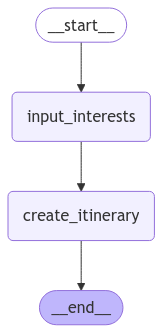

In [7]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [8]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [9]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for a day trip in Seattle with boating and swimming options. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for a day trip in Seattle with boating and swimming options. Need a complete plan


Final Itinerary:
Okay, got it. Let's plan a day trip in Seattle for you with boating and swimming options.

Assuming you're visiting in the summer season and have a reasonable travel budget, here's a suggested itinerary:

Morning (9 AM - 12 PM):
- Start your day with a scenic ferry ride to Bainbridge Island. The 35-minute ferry crossing offers beautiful views of the Seattle skyline and Puget Sound. 
- Once on the island, explore the charming downtown area and grab a coffee or breakfast at one of the local cafes.

Afternoon (12 PM - 4 PM):
- Head back to Seattle and visit Alki Beach, a popular spot for swimming, sunbathing, and taking in the views of the city skyline across the Puget Sound.
- Rent a kayak or stand-up paddleboard and spend an hour or two exploring the calm waters around Alki Beach.
- Have a leisurely lunch at one of the beachfront restauran

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [10]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Okay, let's add white water rafting to the Seattle day trip itinerary:

Morning (9 AM - 12 PM):
- Start your day with a scenic ferry ride to Bainbridge Island. The 35-minute ferry crossing offers beautiful views of the Seattle skyline and Puget Sound.
- Once on the island, explore the charming downtown area and grab a coffee or breakfast at one of the local cafes.

Afternoon (12 PM - 4 PM):
- Head back to Seattle and drive about 45 minutes to the Snoqualmie River, where you'll enjoy a white water rafting adventure. This will be an exciting addition to your day, with Class II-III rapids to navigate.
- After your rafting trip, have a leisurely lunch at one of the riverside restaurants.

Late Afternoon (4 PM - 6 PM): 
- Visit the Chittenden Locks in Ballard, also known as the Ballard Locks. This engineering marvel connects the saltwater of Puget Sound to the freshwater of Lake Union and Lake Washing

#### Run with another session

Now this session will not have the previous conversations and we see it will create a new travel plan with the `white water rafting`  interests, not boating or swim

In [11]:
config = {"configurable": {"thread_id": "11"}}

user_request = "Can you add white water rafting to itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to itinerary


Final Itinerary:
Okay, got it. Based on our previous conversation, it seems your interests include:

- Visiting the Space Needle
- Exploring Pike Place Market
- Going on a white water rafting adventure

Assuming you're visiting Seattle in the summer season and have a reasonable travel budget, here's a suggested day trip itinerary:

9:00 AM - Start your day at the iconic Space Needle. Spend 1-2 hours taking in the 360-degree views of the city from the observation deck.

11:00 AM - Head to the lively Pike Place Market. Wander through the stalls, sample local produce and seafood, and watch the famous fish throwing demonstrations. Plan to spend 1-2 hours exploring the market.

1:00 PM - Break for lunch at one of the many restaurants or food vendors in the Pike Place area. 

2:30 PM - Depart for your white water rafting adventure, which will likely be located outside the city center, about a 30-45 minute drive away. Plan t

## Memory

Memory is key for any agentic conversation which is `Multi-Turn` or `Multi-Agent` colloboration conversation and more so if it spans multiple days. The 3 main aspects of Agents are:
1. Tools
2. Memory
3. Planners


### Explore `External Store` for memory


There are 2 types of memory for AI Agents, short term and long term memory which can be explained below. 
Further reading can be at this [link](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)

Conversation memory can be explained by this diagram below which explains the `turn by turn` conversations which needs to be accessed by agents and then saved as a summary for long term memory

<img src="./images/short-vs-long.png" width="45%"/>



#### Create an external `Memory persistence`

In this section we will leverage multi-thread, multi-session persistence to Chat Messages. Ideally you will leverage persistence like Redis Store etc to save messages per session

##### Memory Management
- We can have several Patterns - we can have each Agents with it's own Session memory
- Or we can have the whole Graph have a combined memory in which case each agent will get it's own memory

The MemorySaver or the Store have the concept of separating sections of memory by Namespaces or by Thread ID's and those can be leveraged to either 1/ Use the graph level message or memory 2/ Ecah agent can have it's own memory via space in saver or else having it's own saver like we do in the `ReACT agent`

<img src="./images/multi_memory_light.png" width="60%" alt='multi_memory_light.png' /> 



In [42]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        return self.store.put(namespace, key, value)
    async def aget(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        res = await self.get(namespace,key)
        return res
    async def aput(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        res = await self.put(namespace, key, value)
        return res
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        res = await self.store.abatch(ops)
        return res


#### Quick look at how to use this store

In [43]:
in_memory_store = CustomMemoryStore(InMemoryStore())
namespace_u = ("chat_messages", "user_id_1")
key_u="user_id_1"
in_memory_store.put(namespace_u, key_u, {"data":["list a"]})
item_u = in_memory_store.get(namespace_u, key_u)
print(item_u.value, item_u.value['data'])

in_memory_store.list_namespaces()

{'data': ['list a']} ['list a']


[('chat_messages', 'user_id_1')]

#### Create the similiar graph as earlier -- note we will not have any mesages in the Graph state as that has been externalized

In [14]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

In [15]:
def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- get the history from the store
    user_u = f"user_id_{config['configurable']['thread_id']}"
    namespace_u = ("chat_messages", user_u)
    store_item = store.get(namespace=namespace_u, key=user_u)
    chat_history_messages = store_item.value['data'] if store_item else []
    print(user_u,chat_history_messages)

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=chat_history_messages))
    print("\nFinal Itinerary:")
    print(response.content)

    #- add back to the store
    store.put(namespace=namespace_u, key=user_u, value={"data":chat_history_messages+[HumanMessage(content=state['user_message']),AIMessage(content=response.content)]})
    
    return {
        **state,
        "itinerary": response.content
    }

In [16]:
in_memory_store_n = CustomMemoryStore(InMemoryStore())

workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile(store=in_memory_store_n)

In [17]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time."
run_travel_planner(user_request, config)


Current User Request: Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.

user_id_1 []

Final Itinerary:
Okay, got it. Let's plan a day trip itinerary for you in Seattle, since you didn't specify a location in California. 

Based on your interest in boating and swimming, here's a suggested one-day itinerary for Seattle in the summer season:

Assumptions:
- Travel budget: Approximately $100-150 per person
- Season: Summer

Itinerary:

9:00 AM - Start your day at Alki Beach. Enjoy the scenic views of the Puget Sound and the Olympic Mountains. Take a stroll along the boardwalk and dip your toes in the water.

11:00 AM - Head to Fishermen's Terminal and take a 1-hour sightseeing cruise around the harbor. You'll get to see the Seattle skyline, the Ballard Locks, and possibly some marine wildlife.

12:30 PM - Grab lunch at one of the seafood restaurants in the Ballard neighborhood, suc

In [18]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add itinerary for white water rafting to this"
run_travel_planner(user_request, config)

Current User Request: Can you add itinerary for white water rafting to this

user_id_1 [HumanMessage(content='Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, got it. Let's plan a day trip itinerary for you in Seattle, since you didn't specify a location in California. \n\nBased on your interest in boating and swimming, here's a suggested one-day itinerary for Seattle in the summer season:\n\nAssumptions:\n- Travel budget: Approximately $100-150 per person\n- Season: Summer\n\nItinerary:\n\n9:00 AM - Start your day at Alki Beach. Enjoy the scenic views of the Puget Sound and the Olympic Mountains. Take a stroll along the boardwalk and dip your toes in the water.\n\n11:00 AM - Head to Fishermen's Terminal and take a 1-hour sightseeing cruise around the harbor. You'll get to see the Seattle skyline, the Balla

#### Quick look at the store

it will show the History of the Chat Messages

In [19]:
print(in_memory_store_n.list_namespaces())
print(in_memory_store_n.get(('chat_messages', 'user_id_1'),'user_id_1').value)

[('chat_messages', 'user_id_1')]
{'data': [HumanMessage(content='Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, got it. Let's plan a day trip itinerary for you in Seattle, since you didn't specify a location in California. \n\nBased on your interest in boating and swimming, here's a suggested one-day itinerary for Seattle in the summer season:\n\nAssumptions:\n- Travel budget: Approximately $100-150 per person\n- Season: Summer\n\nItinerary:\n\n9:00 AM - Start your day at Alki Beach. Enjoy the scenic views of the Puget Sound and the Olympic Mountains. Take a stroll along the boardwalk and dip your toes in the water.\n\n11:00 AM - Head to Fishermen's Terminal and take a 1-hour sightseeing cruise around the harbor. You'll get to see the Seattle skyline, the Ballard Locks, and possibly some marine wildlife.\

### Finally we review the concept of having Each `Agent` be backed by it's own memory

For this we will leverage the RunnableWithMessageHistory when creating the agent
- Here we create to simulate a InMemoryChatMessageHistory, but this will be externalized in produftion use cases
- use this this as a sample

In [20]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory


# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
#model_id = "anthropic.claude-3-sonnet-20240229-v1:0"#
#model_id="anthropic.claude-3-5-sonnet-20240620-v1:0"

provider_id = "anthropic"

chatbedrock_llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. 
    Follow these instructions:
    1. Use the below chat conversation and the latest input from Human to get the user interests.
    2. Always account for travel time and meal times - if its not possible to do everything, then say so.
    3. If the user hasn't stated a time of year or season, assume summer season in {city} and state this assumption in your response.
    4. If the user hasn't stated a travel budget, assume a reasonable dollar amount and state this assumption in your response.
    5. Provide a brief, bulleted itinerary in chronological order with specific hours of day."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])
chain = itinerary_prompt | chatbedrock_llm 


history = InMemoryChatMessageHistory()
def get_history():
    return history

wrapped_chain = RunnableWithMessageHistory(
    chain,
    get_history,
    history_messages_key="chat_history",
)


In [21]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- each agent manages it's memory
    response = wrapped_chain.invoke({"city": state['city'], "user_message": state['user_message'], "input": state['user_message']} )
    print("\nFinal Itinerary:")
    print(response.content)
    
    return {
        **state,
        "itinerary": response.content
    }

In [22]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile()

In [23]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Okay, got it. Based on your interest in boating and swimming, here is a suggested day trip itinerary for Seattle:

Assumptions:
- Visiting in the summer season
- Reasonable travel budget of $100-200 per person

Itinerary:

9:00 AM - Start your day at Fishermen's Terminal, home to the largest commercial fishing fleet in the Pacific Northwest. Explore the docks and watch the boats come and go.

10:30 AM - Head to Alki Beach, one of Seattle's most popular beaches. Spend a couple hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains.

12:30 PM - Grab lunch at one of the beachfront restaurants or cafes on Alki, such as Salty's on Alki or Pegasus Pizza & Pasta.

2:00 PM - Take a ferry ride across the Puget Sound to Bainbridge Island. Rent a kayak or stand-up paddleboard and explore the scenic coastline.

4:30 PM - Return to Seattle via the ferr

In [24]:
user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Okay, got it. Let's add white water rafting to the Seattle day trip itinerary:

Assumptions:
- Visiting in the summer season
- Reasonable travel budget of $100-200 per person

Itinerary:

9:00 AM - Start your day at Fishermen's Terminal, home to the largest commercial fishing fleet in the Pacific Northwest. Explore the docks and watch the boats come and go.

10:30 AM - Head to Alki Beach, one of Seattle's most popular beaches. Spend a couple hours swimming, sunbathing, and enjoying the views of the Puget Sound and the Olympic Mountains.

12:30 PM - Grab lunch at one of the beachfront restaurants or cafes on Alki, such as Salty's on Alki or Pegasus Pizza & Pasta.

2:00 PM - Drive about 1.5 hours east of Seattle to the Snoqualmie River for a white water rafting adventure. This will take up the majority of your afternoon.

5:30 PM - Return to Seattle after your rafting trip. Head to Lake Union and v

### Memory Management tools from Langmem.

LangMem has released new memory management features which is a complete memory SDK which includes all the types of memory semantic, procedural, entity).

[LangMem](https://langchain-ai.github.io/langmem/hot_path_quickstart/#prerequisites)

[Langmem memory management](https://langchain-ai.github.io/langmem/reference/memory/#langmem.create_memory_store_manager)



In [ ]:
#!pip install langmem

## Conclusion

You have successfully executed a simple LangGraph implementation, this lab demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

Please proceed to the next lab

### Lang mem concepts

In [ ]:
# - set your credentials if needed


## Let us examine the 2 critical building blocks for Langmem

1. MemoryStoreManager
2. MemoryManager

In [8]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        print(f"PUT::namespace={namespace}, key={key}, value={value}:")
        return self.store.put(namespace, key, value)
    async def aget(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        res = await self.get(namespace,key)
        return res
    async def aput(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        res = self.put(namespace, key, value) # cannot await this as this returns a none and also is a sync function
        print(f"ASYN-PUT::::namespace={namespace}, key={key}, value={value}:")
        return None
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        print(f"ASYNC::BATCH::::ops={ops}:")
        res = await self.store.abatch(ops)
        return res

In [3]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.store.memory import InMemoryStore
from langmem import create_memory_store_manager
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langmem import create_manage_memory_tool, create_search_memory_tool
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3
from IPython.display import Image, display
from langmem import create_memory_manager # 
from pydantic import BaseModel

class Triple(BaseModel): # 
    """Store all new facts, preferences, and relationships as triples."""
    subject: str
    predicate: str
    object: str
    context: str | None = None

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore())

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")


llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

memory_manager = create_memory_store_manager(
    llm,
    namespace=("chat", "{user_id}", "triples"),
    schemas=[Triple],
    instructions="Extract all user information and events as triples.",
    enable_inserts=True,
    enable_deletes=True,
)
messages = [
        {
            "role": "user",
            "content": "Alice manages the ML team and mentors Bob, who is also on the team.",
        },
]
#- Will not work - needs a RunnableContext
#- raise RuntimeError("Called get_config outside of a runnable context")
#- memory_manager.invoke({"messages": messages}) 

# Define app with store context
@entrypoint(store=in_memory_store) # 
def app(messages: list):
    response = llm.invoke(
        [
            {
                "role": "system",
                "content": "You are a helpful assistant.",
            },
            *messages
        ]
    )

    # Extract and store triples (Uses store from @entrypoint context)
    memory_manager.invoke({"messages": messages}) 
    return response

app.invoke(messages, config={"configurable": {"user_id": "user123"}})

PUT::namespace=('chat', 'user123', 'triples'), key=ac65cb2a-eb0e-4c68-8bd3-7ea60978da88, value={'kind': 'Triple', 'content': {'subject': 'Alice', 'predicate': 'manages', 'object': 'ML team', 'context': None}}:PUT::namespace=('chat', 'user123', 'triples'), key=460fe177-274b-422a-b642-1283648fc977, value={'kind': 'Triple', 'content': {'subject': 'Alice', 'predicate': 'mentors', 'object': 'Bob', 'context': None}}:

PUT::namespace=('chat', 'user123', 'triples'), key=0ece680e-48ed-4f39-aa76-f7db81a05ec5, value={'kind': 'Triple', 'content': {'subject': 'Bob', 'predicate': 'is_on', 'object': 'ML team', 'context': None}}:


AIMessage(content='Okay, got it. Alice is the manager of the ML (machine learning) team, and she mentors Bob, who is also a member of the same ML team.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '08442a32-f17c-427f-8d3e-3584546b18e9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sat, 01 Mar 2025 06:53:35 GMT', 'content-type': 'application/json', 'content-length': '313', 'connection': 'keep-alive', 'x-amzn-requestid': '08442a32-f17c-427f-8d3e-3584546b18e9'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [494]}}, id='run-5eff72ae-717b-49a4-b2d7-766e14a22c40-0', usage_metadata={'input_tokens': 30, 'output_tokens': 39, 'total_tokens': 69})

#### Create_memory _manager which does not use the store

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.store.memory import InMemoryStore
from langmem import create_memory_store_manager
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langmem import create_manage_memory_tool, create_search_memory_tool
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3
from IPython.display import Image, display
from langmem import create_memory_manager # 
from pydantic import BaseModel

class Triple(BaseModel): # 
    """Store all new facts, preferences, and relationships as triples."""
    subject: str
    predicate: str
    object: str
    context: str | None = None

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore())

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")


llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

memory_manager = create_memory_manager(
    llm,
    #namespace=("chat", "{user_id}", "triples"),
    schemas=[Triple],
    instructions="Extract all user information and events as triples.",
    enable_inserts=True,
    enable_deletes=True,
)
messages = [
        {
            "role": "user",
            "content": "Alice manages the ML team and mentors Bob, who is also on the team.",
        },
]

memory_manager.invoke({"messages": messages}) 



[ExtractedMemory(id='6dd5698a-6c9a-4180-a814-bdf9577d13ec', content=Triple(subject='Alice', predicate='manages', object='ML team', context=None)),
 ExtractedMemory(id='395aab24-bac8-4f16-beb6-9091bcc8ecf1', content=Triple(subject='Alice', predicate='mentors', object='Bob', context=None)),
 ExtractedMemory(id='f899b2c6-c723-4f3f-81bc-aae634b1fc94', content=Triple(subject='Bob', predicate='is on', object='ML team', context=None))]

#### Quick start to lang mem using a react agent

This uses the Store manager which is used from the context and the config and the state

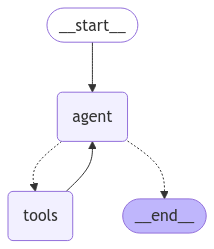

PUT::res::namespace=('memories',), key=6dd6e6db-e4a6-4c9e-b3a9-5cdd68117653, value={'content': 'User prefers dark mode'}:
================================ Human Message =================================

Remember that I prefer dark mode.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'manage_memory', 'input': {'action': 'create', 'content': 'User prefers dark mode'}, 'id': 'tooluse_JDga5UmbSj64G0mHbcohbg'}]
Tool Calls:
  manage_memory (tooluse_JDga5UmbSj64G0mHbcohbg)
 Call ID: tooluse_JDga5UmbSj64G0mHbcohbg
  Args:
    action: create
    content: User prefers dark mode
================================= Tool Message =================================
Name: manage_memory

created memory 6dd6e6db-e4a6-4c9e-b3a9-5cdd68117653
================================== Ai Message ==================================

Rationale:
The user has indicated that they prefer dark mode. To remember this preference, I have created a new memory with

[None, None, None, None]

In [209]:
# Import core components 
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langmem import create_manage_memory_tool, create_search_memory_tool
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3
from IPython.display import Image, display

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore())

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")


llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Create an agent with memory capabilities 
agent = create_react_agent(
    llm,
    tools=[
        # Memory tools use LangGraph's BaseStore for persistence (4)
        create_manage_memory_tool(namespace=("memories",)),
        create_search_memory_tool(namespace=("memories",)),
    ],
    store=in_memory_store,
    state_modifier="""
    For every response output the details of what was the rationale for the response
    """,
)
# Store a new memory 

display(Image(agent.get_graph().draw_mermaid_png()))

response = agent.invoke(
    {"messages": [{"role": "user", "content": "Remember that I prefer dark mode."}]}
)
print([x.pretty_print() for x in response["messages"] ])
# Retrieve the stored memory 


response = agent.invoke(
    {"messages": [{"role": "user", "content": "What are my lighting preferences?"}]}
)
#print(response["messages"][-1].content)
[x.pretty_print() for x in response["messages"] ]


In [210]:
#- {'3f8125d8-f922-4672-b88c-9a369f7e61c6': Item(namespace=['memories'], key='3f8125d8-f922-4672-b88c-9a369f7e61c6', value={'content': 'The user prefers dark mode.'}, created_at='2025-02-25T19:58:57.511231+00:00', updated_at='2025-02-25T19:58:57.511234+00:00')}
#- in_memory_store.store._data[('memories',)]
namespace_u = ('memories',)
key_u='289a2f0e-f9dc-461e-b257-a7d221d288c3'
#item_u = in_memory_store.get(namespace_u, key_u)
#print(item_u.value, item_u.value['data'])

print(in_memory_store.store.list_namespaces())
print(in_memory_store.store.search(("memories",)))
in_memory_store.store._data

[('memories',)]
[Item(namespace=['memories'], key='6dd6e6db-e4a6-4c9e-b3a9-5cdd68117653', value={'content': 'User prefers dark mode'}, created_at='2025-03-01T01:17:27.096336+00:00', updated_at='2025-03-01T01:17:27.096342+00:00', score=None)]


defaultdict(dict,
            {('memories',): {'6dd6e6db-e4a6-4c9e-b3a9-5cdd68117653': Item(namespace=['memories'], key='6dd6e6db-e4a6-4c9e-b3a9-5cdd68117653', value={'content': 'User prefers dark mode'}, created_at='2025-03-01T01:17:27.096336+00:00', updated_at='2025-03-01T01:17:27.096342+00:00')}})

### Now we wil review the concept of 
1. Populating the Memory with every turn by turnby turn conversation
2. Or updating it Peridically 

### Review the condition for managing for multiple users for turn by  turn
1. User A having memory defined and so the agents is able to review and get that 
2. user B not having any memory and the agent returns `non hallucinated` answer

we will the `store` put being called multiple times as the memory gets updates. The create_store_manager uses a get_store() call which in turn calls the context and State object to tget the store

In [212]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langgraph.utils.config import get_store 
from langmem import (
    # Lets agent create, update, and delete memories 
    create_manage_memory_tool,
)

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)
#- can eb a function which gets converted to a Runnablecallable or can eb a ChatPromptTemplate which becomes a System prompt
def prompt(state):
    """Prepare the messages for the LLM."""
    # Get store from configured contextvar; 
    print(f"prompt::state is {state}:")
    store = get_store() # Same as that provided to `create_react_agent`
    memories = store.search(
        # Search within the same namespace as the one
        # we've configured for the agent
        ("memories",),
        query=state["messages"][-1].content,
    )
    system_msg = f"""You are a helpful assistant.

## Memories
<memories>
{memories}
</memories>
"""
    return [{"role": "system", "content": system_msg}, *state["messages"]]


# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 

checkpointer = MemorySaver() # Checkpoint graph state 

agent = create_react_agent( 
    llm,
    prompt=prompt,
    tools=[ # Add memory tools 
        # The agent can call "manage_memory" to
        # create, update, and delete memories by ID
        # Namespaces add scope to memories. To
        # scope memories per-user, do ("memories", "{user_id}"): 
        create_manage_memory_tool(namespace=("memories",)),
    ],
    # Our memories will be stored in this provided BaseStore instance
    store=in_memory_store,
    # And the graph "state" will be checkpointed after each node
    # completes executing for tracking the chat history and durable execution
    checkpointer=checkpointer, 
)

config = {"configurable": {"thread_id": "thread-a"}}

# Use the agent. The agent hasn't saved any memories,
# so it doesn't know about us
response = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "Know which display mode I prefer?"}
        ]
    },
    config=config,
)
print(response["messages"][-1].content)
# Output: "I don't seem to have any stored memories about your display mode preferences..."

response = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "dark. Remember that."}
        ]
    },
    # We will continue the conversation (thread-a) by using the config with
    # the same thread_id
    config=config,
)

print(in_memory_store.store._data)
[x.pretty_print() for x in response["messages"] ]

prompt::state is {'messages': [HumanMessage(content='Know which display mode I prefer?', additional_kwargs={}, response_metadata={}, id='fa674616-6a71-4c46-bd94-6d202985be86')], 'is_last_step': False, 'remaining_steps': 24}:
PUT::res::namespace=('memories',), key=47a71c61-b652-4ce6-8778-c54124803c4f, value={'content': 'User display mode preference'}:
prompt::state is {'messages': [HumanMessage(content='Know which display mode I prefer?', additional_kwargs={}, response_metadata={}, id='fa674616-6a71-4c46-bd94-6d202985be86'), AIMessage(content=[{'type': 'text', 'text': "I'm afraid I don't have any information about your display mode preferences stored in my memory. As an AI assistant, I don't have any pre-existing knowledge about your personal preferences unless you've explicitly provided that information to me before."}, {'type': 'tool_use', 'name': 'manage_memory', 'input': {'action': 'create', 'content': 'User display mode preference'}, 'id': 'tooluse_skAf4UjwQsioHhDVc-vu7w'}], additi

[None, None, None, None, None, None, None, None]

#### Now invoke with a user with no `memory`

In [213]:
response = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "what is my mode preference?"}
        ]
    },
    # We will continue the conversation (thread-a) by using the config with
    # the same thread_id
    config=config,
)
[x.pretty_print() for x in response["messages"] ]

prompt::state is {'messages': [HumanMessage(content='Know which display mode I prefer?', additional_kwargs={}, response_metadata={}, id='fa674616-6a71-4c46-bd94-6d202985be86'), AIMessage(content=[{'type': 'text', 'text': "I'm afraid I don't have any information about your display mode preferences stored in my memory. As an AI assistant, I don't have any pre-existing knowledge about your personal preferences unless you've explicitly provided that information to me before."}, {'type': 'tool_use', 'name': 'manage_memory', 'input': {'action': 'create', 'content': 'User display mode preference'}, 'id': 'tooluse_skAf4UjwQsioHhDVc-vu7w'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '18e64343-923c-4031-8615-73ec60136c9d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sat, 01 Mar 2025 01:20:00 GMT', 'content-type': 'application/json', 'content-length': '589', 'connection': 'keep-alive', 'x-amzn-requestid': '18e64343-923c-4031-8615-73ec60136c9d'}, 'RetryAttempts

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [214]:
# New thread = new conversation!
new_config = {"configurable": {"thread_id": "thread-b"}}
# The agent will only be able to recall
# whatever it explicitly saved using the manage_memories tool
response = agent.invoke(
    {"messages": [{"role": "user", "content": "Hey there. Do you remember me? What are my preferences?"}]},
    config=new_config,
)
#print(response["messages"][-1].content)
[x.pretty_print() for x in response["messages"] ]

prompt::state is {'messages': [HumanMessage(content='Hey there. Do you remember me? What are my preferences?', additional_kwargs={}, response_metadata={}, id='582a57dd-d9f8-40d8-ad66-5d06b511b4ff')], 'is_last_step': False, 'remaining_steps': 24}:
prompt::state is {'messages': [HumanMessage(content='Hey there. Do you remember me? What are my preferences?', additional_kwargs={}, response_metadata={}, id='582a57dd-d9f8-40d8-ad66-5d06b511b4ff'), AIMessage(content=[{'type': 'tool_use', 'name': 'manage_memory', 'input': {'action': 'read'}, 'id': 'tooluse_mvjJD6UlQsOKiw8QAvTUlw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '4f9d582f-2291-4fb5-b786-ca166e66f4d6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sat, 01 Mar 2025 01:20:14 GMT', 'content-type': 'application/json', 'content-length': '279', 'connection': 'keep-alive', 'x-amzn-requestid': '4f9d582f-2291-4fb5-b786-ca166e66f4d6'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [

[None, None, None, None]

### Prompt Optimizers using Bedrock and Langmem

In [215]:
from langmem import create_multi_prompt_optimizer

optimizer = create_multi_prompt_optimizer(llm)

# Example conversation with feedback
conversation = [
    {"role": "user", "content": "Tell me about the solar system"},
    {"role": "assistant", "content": "The solar system consists of..."},
]
feedback = {"clarity": "needs more structure"}

# Use conversation history to improve the prompts
trajectories = [(conversation, feedback)]
prompts = [
    {"name": "research", "prompt": "Research the given topic thoroughly"},
    {"name": "summarize", "prompt": "Summarize the research findings"},
]
better_prompts = await optimizer.ainvoke(
    {"trajectories": trajectories, "prompts": prompts}
)
print(better_prompts)

[{'name': 'research', 'prompt': 'Provide a detailed overview of the solar system, including:\n\nIntroduction\n- Brief description of the solar system and its place in the universe\n\nKey Components\n- The sun and its role as the center of the solar system\n- The 8 major planets (Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune)\n- Moons, asteroids, comets, and other notable features\n\nDescriptions of Each Component\n- For each planet, describe its size, composition, orbit, and any unique characteristics\n- Highlight key facts about the sun, moons, asteroids, etc.\n\nConclusion\n- Summarize the overall structure and scale of the solar system\n\nPlease let me know if you need any clarification or have additional details you would like me to include.'}, {'name': 'summarize', 'prompt': 'Summarize the research findings'}]


#### Hello World for `asyncio` a quick recap

In [216]:
import asyncio

async def say_hello(name, delay):
    res = await asyncio.sleep(delay)
    print(f"Hello, {name}!::delay={delay}::res={res}")

async def main():
    # Run tasks concurrently
    await asyncio.gather(
        say_hello("Alice", 4),
        say_hello("Bob", 5),
        say_hello("Bob_2", 5),
        say_hello("Charlie", 1)
    )
    # tasks = [process_and_update(item) for item in items]
    # results = await asyncio.gather(*tasks)



# In Jupyter, you can directly await coroutines in a cell since it has it's own event loop
await main()

Hello, Charlie!::delay=1::res=None
Hello, Alice!::delay=4::res=None
Hello, Bob!::delay=5::res=None
Hello, Bob_2!::delay=5::res=None


#### Run the `memory` in a-sync for offline memory aggregation

In [9]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        print(f"PUT::namespace={namespace}, key={key}, value={value}:")
        return self.store.put(namespace, key, value)
    async def aget(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        res = await self.get(namespace,key)
        return res
    async def aput(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        res = self.put(namespace, key, value) # cannot await this as this returns a none and also is a sync function
        print(f"ASYN-PUT::::namespace={namespace}, key={key}, value={value}:")
        return None
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        print(f"ASYNC::BATCH::::ops={ops}:")
        res = await self.store.abatch(ops)
        return res

In [224]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.store.memory import InMemoryStore

from langmem import ReflectionExecutor, create_memory_store_manager
from langchain.chat_models import init_chat_model
from langmem import ReflectionExecutor, create_memory_store_manager

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Create memory manager Runnable to extract memories from conversations
memory_manager = create_memory_store_manager(
    llm,
    # Store memories in the "memories" namespace (aka directory)
    namespace=("memories",),  # 
)
# Wrap memory_manager to handle deferred background processing 
executor = ReflectionExecutor(memory_manager)

#- does not have chat history so not of much use
llm_chat_model = init_chat_model("anthropic.claude-3-haiku-20240307-v1:0", model_provider='bedrock')

@entrypoint(store=in_memory_store)  # Create a LangGraph workflow
async def chat(message: str):
    response = llm.invoke(message)
    #response = llm_chat_model.invoke(message)

    # memory_manager extracts memories from conversation history
    # We'll provide it in OpenAI's message format
    to_process = {"messages": [{"role": "user", "content": message}] + [response]}
    await memory_manager.ainvoke(to_process)  # 
    return response.content

# Run conversation as normal
response = await chat.ainvoke(
    "I like dogs. My dog's name is Dexter.",
)
print(response)



ASYNC::BATCH::::ops=[SearchOp(namespace_prefix=('memories',), filter=None, limit=10, offset=0, query="================================== Ai Message ==================================\n\nThat's great that you like dogs! Dexter is a nice name for a dog. Dogs can make wonderful companions. What do you enjoy most about having Dexter as a pet?")]:
PUT::namespace=('memories',), key=11a79c24-7ab2-4904-b408-0b427e9ad62c, value={'kind': 'Memory', 'content': {'content': "The user likes dogs. Their dog's name is Dexter."}}:
ASYN-PUT::::namespace=('memories',), key=11a79c24-7ab2-4904-b408-0b427e9ad62c, value={'kind': 'Memory', 'content': {'content': "The user likes dogs. Their dog's name is Dexter."}}:
That's great that you like dogs! Dexter is a nice name for a dog. Dogs can make wonderful companions. What do you enjoy most about having Dexter as a pet?


In [225]:
response = await chat.ainvoke(
    "what gift should i buy for him",
)
print(response)

ASYNC::BATCH::::ops=[SearchOp(namespace_prefix=('memories',), filter=None, limit=10, offset=0, query="================================== Ai Message ==================================\n\nHere are some gift ideas you could consider for him:\n\n1. Tech gadgets - Things like a new smartphone, smartwatch, wireless headphones, portable charger, etc. are often popular gifts for men.\n\n2. Experiences - Tickets to a sporting event, concert, or activity he enjoys like golfing, fishing, or a cooking class.\n\n3. Apparel - A nice jacket, shirt, pair of jeans, or accessories like a belt, wallet, or sunglasses.\n\n4. Hobby-related gifts - If you know his hobbies, consider getting him something related to that like tools, equipment, books, or supplies.\n\n5. Grooming products - High-quality shaving kit, cologne, skincare products, etc.\n\n6. Home/office items - A nice desk organizer, coffee table book, home decor piece, or bar accessories.\n\n7. Gift cards - If you're unsure, a gift card to his favo

In [226]:
print(in_memory_store.search(("memories",)))

[Item(namespace=['memories'], key='11a79c24-7ab2-4904-b408-0b427e9ad62c', value={'kind': 'Memory', 'content': {'content': "The user likes dogs. Their dog's name is Dexter."}}, created_at='2025-03-01T01:23:04.510885+00:00', updated_at='2025-03-01T01:23:04.510887+00:00', score=None), Item(namespace=['memories'], key='1a5c5af3-8edb-4d2b-8c4b-ec47864735c1', value={'kind': 'Memory', 'content': {'content': "The user is looking for a gift to buy for someone, likely a male. Some potential gift ideas include tech gadgets, experiences, apparel, hobby-related items, grooming products, home/office items, and gift cards. The best gift will depend on the recipient's personal interests and preferences."}}, created_at='2025-03-01T01:23:23.049803+00:00', updated_at='2025-03-01T01:23:23.049807+00:00', score=None)]


In [227]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.store.memory import InMemoryStore

from langmem import ReflectionExecutor, create_memory_store_manager
from langchain.chat_models import init_chat_model
from langmem import ReflectionExecutor, create_memory_store_manager

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Create memory manager Runnable to extract memories from conversations
memory_manager = create_memory_store_manager(
    llm,
    # Store memories in the "memories" namespace (aka directory)
    namespace=("memories",),  # 
)
# Wrap memory_manager to handle deferred background processing 
executor = ReflectionExecutor(memory_manager)

#- does not have chat history so not of much use
llm_chat_model = init_chat_model("anthropic.claude-3-haiku-20240307-v1:0", model_provider='bedrock')

@entrypoint(store=in_memory_store)  # Create a LangGraph workflow
async def chat(message: str):
    response = llm.invoke(message)
    #response = llm_chat_model.invoke(message)

    # memory_manager extracts memories from conversation history
    # We'll provide it in OpenAI's message format
    to_process = {"messages": [{"role": "user", "content": message}] + [response]}

    # Wait 30 minutes before processing
    # If new messages arrive before then:
    # 1. Cancel pending processing task
    # 2. Reschedule with new messages included
    delay = 0.5 # In practice would choose longer (30-60 min)
    delay = 30
    # depending on app context.
    executor.submit(to_process, after_seconds=delay)
    #await memory_manager.ainvoke(to_process)  # 
    return response.content

# Run conversation as normal
response = await chat.ainvoke(
    "I like dogs. My dog's name is Dexter.",
)
print(response)

That's great that you like dogs! Dexter is a nice name for a dog. Dogs can make wonderful companions. What do you enjoy most about having Dexter as a pet?


Error in local reflection worker: CANCELLED: <Future at 0x30173b690 state=cancelled>


PUT::namespace=('memories',), key=33f57324-1f54-43dc-bc43-afbf0f9cecc8, value={'kind': 'Memory', 'content': {'content': 'The user asked for a gift recommendation for someone, indicating they want to buy a gift for this person. This suggests the user cares about the recipient and wants to get them something thoughtful and useful. The user did not provide any additional details about the recipient, so I should provide a range of general gift ideas that could work for different types of people and relationships.'}}:


### Run right away and you will see the memory not yet populated

In [228]:
print(in_memory_store.search(("memories",)))

[]


#### If you run this cell before 30 sec you will that the memory will be just this last message

if you run post 30 sec you will both the memories populated

In [229]:
response = await chat.ainvoke(
    "what gift should i buy for him",
)
print(response)
print(in_memory_store.search(("memories",)))

Here are some gift ideas that could work well, depending on the person's interests and your relationship:

- If they're into a particular hobby or interest, consider getting them something related to that - e.g. a book, tool, accessory, etc. related to their hobby.

- Gift cards to their favorite restaurant, coffee shop, or store are always appreciated.

- Tech gadgets or accessories like a nice pair of headphones, a portable charger, a smart speaker, etc.

- Subscription boxes for things like monthly book/music/snack deliveries.

- Tickets to an event, show, or experience they'd enjoy.

- A nice bottle of their favorite liquor or wine.

- A cozy blanket, robe, or slippers if they like to relax at home.

- A grooming/self-care gift set with cologne, aftershave, bath products, etc.

- A personalized item like a monogrammed wallet, engraved pen, or custom photo print.

The key is to think about their personality, hobbies, and lifestyle to pick something thoughtful and useful for them. It

#### Run right away -- this should be empty

In [239]:
print(in_memory_store.search(("memories",)))

[Item(namespace=['memories'], key='33f57324-1f54-43dc-bc43-afbf0f9cecc8', value={'kind': 'Memory', 'content': {'content': 'The user asked for a gift recommendation for someone, indicating they want to buy a gift for this person. This suggests the user cares about the recipient and wants to get them something thoughtful and useful. The user did not provide any additional details about the recipient, so I should provide a range of general gift ideas that could work for different types of people and relationships.'}}, created_at='2025-03-01T01:24:29.253347+00:00', updated_at='2025-03-01T01:24:29.253349+00:00', score=None)]


### Run after 30 sec and you will the LAST message got added to the Memory but the very first one is no longer part of the memory

In [240]:
print(in_memory_store.search(("memories",)))

[Item(namespace=['memories'], key='33f57324-1f54-43dc-bc43-afbf0f9cecc8', value={'kind': 'Memory', 'content': {'content': 'The user asked for a gift recommendation for someone, indicating they want to buy a gift for this person. This suggests the user cares about the recipient and wants to get them something thoughtful and useful. The user did not provide any additional details about the recipient, so I should provide a range of general gift ideas that could work for different types of people and relationships.'}}, created_at='2025-03-01T01:24:29.253347+00:00', updated_at='2025-03-01T01:24:29.253349+00:00', score=None)]


### Semantic memories

#### Extract using the semantic memories -- Use Pydantic object to extract the Memories
The manager simply manages the LLM call.s If we do not pass in exisiting memories - it will not have any context of previous conversation


In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore

from langmem import create_manage_memory_tool, create_search_memory_tool
from langmem import create_memory_manager # 
from pydantic import BaseModel

class Triple(BaseModel): # 
    """Store all new facts, preferences, and relationships as triples."""
    subject: str
    predicate: str
    object: str
    context: str | None = None


# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Configure extraction
memory_manager = create_memory_manager(  
    llm,
    schemas=[Triple], 
    instructions="Extract user preferences and any other useful information",
    enable_inserts=True,
    enable_deletes=True,
)


# First conversation - extract triples
conversation1 = [
    {"role": "user", "content": "Alice manages the ML team and mentors Bob, who is also on the team."}
]
memories = memory_manager.invoke({"messages": conversation1})
print("After first conversation:")
for m in memories:
    print(m)

# Second conversation - update and add triples
conversation2 = [
    {"role": "user", "content": "Bob now leads the ML team and the NLP project."}
]
update = memory_manager.invoke({"messages": conversation2, "existing": memories})
print("After second conversation:")
for m in update:
    print(m)

# Delete triples about an entity
existing = [m for m in update if isinstance(m.content, Triple)]
conversation3 = [
    {"role": "user", "content": "Alice left the company."}
]
final = memory_manager.invoke({"messages": conversation3, "existing": existing})
print("After third conversation:")
for m in final:
    print(m)

#- Now call with no PREVIOUS
final_no_mem = memory_manager.invoke({"messages": conversation3, "existing": []})
print("After FOURTH conversation: NO PREVIOUS MEMORIES::")
for m in final_no_mem:
    print(m)    

After first conversation:
ExtractedMemory(id='161b0b6a-e978-43d2-973f-811b31e6ab52', content=Triple(subject='Alice', predicate='manages', object='ML team', context=None))
ExtractedMemory(id='ea1a6739-5bfe-430d-82c9-dc5a451de25f', content=Triple(subject='Alice', predicate='mentors', object='Bob', context=None))
ExtractedMemory(id='4ba5e911-afc5-4538-bd76-32ff295de08a', content=Triple(subject='Bob', predicate='is on', object='ML team', context=None))
After second conversation:
ExtractedMemory(id='b327fabe-4e8f-41fc-b3c7-7223d010caf3', content=Triple(subject='Bob', predicate='leads', object='ML team', context='None'))
ExtractedMemory(id='54c040b0-ef11-4ed2-8557-b7f432ff5cfe', content=Triple(subject='Bob', predicate='leads', object='NLP project', context='None'))
ExtractedMemory(id='161b0b6a-e978-43d2-973f-811b31e6ab52', content=Triple(subject='Alice', predicate='manages', object='ML team', context=None))
ExtractedMemory(id='ea1a6739-5bfe-430d-82c9-dc5a451de25f', content=Triple(subject='Al

### Use these in a chatbot

#### Some basic examples for `entrypoint`. This will wrap a function and create a LangGraph out of it

In [253]:
import time

from langgraph.func import entrypoint, task
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

@task
def compose_essay(topic: str) -> str:
    time.sleep(1.0)  # Simulate slow operation
    return f"An essay about {topic}"

# - previous value is accessible only if check pointer Memory saver is there
@entrypoint(checkpointer=MemorySaver())
def review_workflow(topic: str, previous: Optional[str] = None) -> dict:
    print(f"In the review_workflow::entry:point::: previous value={previous}")
    essay_future = compose_essay(topic)
    essay = essay_future.result()
    human_review = interrupt({"question": "Please provide a review","essay": essay})

    #- if we want to return a diferent value and save different then use the below. 
    # #- save is what gets saved in the chekpoiint available for NEXT invocations. value is what gets returned
    #- entrypoint.final(value=previous, save=2 * number)
    
    #- either return this simple value
    final_result = {"essay": essay,"review": human_review,}
    # return final_result

    return entrypoint.final(value=final_result, save=essay) # return the dict but save just the essay 

# Example configuration for the workflow
config = {"configurable": {"thread_id": "some_thread"}}

# Topic for the essay
topic = "dogs"

# Stream the workflow to generate the essay and await human review
for result in review_workflow.stream(topic, config):
    print(result)

# Example human review provided after the interrupt
human_review = "This essay is great."

# Resume the workflow with the provided human review
for result in review_workflow.stream(Command(resume=human_review), config):
    print(result)


In the review_workflow::entry:point::: previous value=None
{'compose_essay': 'An essay about dogs'}
{'__interrupt__': (Interrupt(value={'question': 'Please provide a review', 'essay': 'An essay about dogs'}, resumable=True, ns=['review_workflow:18eceb1f-54c5-cae6-4b8f-9495cb4503ba'], when='during'),)}
In the review_workflow::entry:point::: previous value=None
{'review_workflow': {'essay': 'An essay about dogs', 'review': 'This essay is great.'}}


In [254]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore

from langmem import create_manage_memory_tool, create_search_memory_tool

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

class Triple(BaseModel): # 
    """Store all new facts, preferences, and relationships as triples."""
    subject: str
    predicate: str
    object: str
    context: str | None = None
    
llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)
memory_manager = create_memory_store_manager(
    llm,
    namespace=("chat", "{user_id}", "triples"),
    schemas=[Triple],
    instructions="Extract all user information and events as triples.",
    enable_inserts=True,
    enable_deletes=True,
)

# Run extraction in background
@entrypoint(store=in_memory_store)  # (1)
def app(messages: list):
    response = llm.invoke(
        [
            {
                "role": "system",
                "content": "You are a helpful assistant.",
            },
            *messages,
        ]
    )

    # Extract and store triples (Uses store from @entrypoint context)
    memory_manager.invoke({"messages": messages})
    return response

#- no implemented for simple apps with entry-point
#display(Image(app.get_graph().draw_mermaid_png()))

res = app.invoke(
    [
        {
            "role": "user",
            "content": "Alice manages the ML team and mentors Bob, who is also on the team.",
        }
    ],
    {"configurable": {"user_id": "usr123"}}
)

print(in_memory_store.search(("memories",)))

print(res)

# [
#     Item(
#         namespace=["memories"],
#         key="5ca8dacc-7d46-40bb-9b3d-f4c2dc5c4b30",
#         value={"content": "Alice is the manager of the ML (Machine Learning) team"},
#         created_at="2025-02-11T00:28:01.688490+00:00",
#         updated_at="2025-02-11T00:28:01.688499+00:00",
#         score=None,
#     ),
#     Item(
#         namespace=["memories"],
#         key="586783fa-e501-4835-8651-028c2735f0d0",
#         value={"content": "Bob works on the ML team"},
#         created_at="2025-02-11T00:28:04.408826+00:00",
#         updated_at="2025-02-11T00:28:04.408841+00:00",
#         score=None,
#     ),
#     Item(
#         namespace=["memories"],
#         key="19f75f64-8787-4150-a439-22068b00118a",
#         value={"content": "Alice mentors Bob on the ML team"},
#         created_at="2025-02-11T00:28:06.951838+00:00",
#         updated_at="2025-02-11T00:28:06.951847+00:00",
#         score=None,
#     ),
# ]

PUT::namespace=('chat', 'usr123', 'triples'), key=3057ffa8-a1d8-49ed-ad34-a5d690337cc1, value={'kind': 'Triple', 'content': {'subject': 'Alice', 'predicate': 'manages', 'object': 'ML team', 'context': None}}:PUT::namespace=('chat', 'usr123', 'triples'), key=360e7daa-87fe-46dd-b2e7-fd5315ecf59b, value={'kind': 'Triple', 'content': {'subject': 'Alice', 'predicate': 'mentors', 'object': 'Bob', 'context': None}}:
PUT::namespace=('chat', 'usr123', 'triples'), key=a592daa6-44b4-4bbc-8d6f-217d9d0f8136, value={'kind': 'Triple', 'content': {'subject': 'Bob', 'predicate': 'is_on', 'object': 'ML team', 'context': None}}:

[]
content='Okay, got it. Alice is the manager of the ML (machine learning) team, and she mentors Bob, who is also a member of the same ML team.' additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': 'd58adf81-b7ed-4e1b-b92f-f61de5cb42f1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sat, 01 Mar 2025 01:46:27 GMT', 'content-type': 'application/json', 'cont

In [259]:
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore

from langmem import create_manage_memory_tool, create_search_memory_tool

# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)



def prompt(state):
    """Prepare messages with context from existing memories."""
    print(f" IN PROMPT:: we will search the store for memories and ADD to the system messages::QUERY={state['messages'][-1].content}::state={state}::")
    
    memories = in_memory_store.search(
        ("memories",),
        query=state["messages"][-1].content,
    )
    system_msg = f"""You are a memory manager. Extract and manage all important knowledge, rules, and events using the provided tools.



Existing memories:
<memories>
{memories}
</memories>

Use the manage_memory tool to update and contextualize existing memories, create new ones, or delete old ones that are no longer valid.
You can also expand your search of existing memories to augment using the search tool."""
    return [{"role": "system", "content": system_msg}, *state["messages"]]


# Create the memory extraction agent
agent_memories = create_react_agent(
    llm,
    prompt=prompt,
    tools=[
        # Agent can create/update/delete memories
        create_manage_memory_tool(namespace=("memories",)),
        create_search_memory_tool(namespace=("memories",)),
    ],
)


# Run extraction in background
@entrypoint(store=in_memory_store)  # (1)
def app(messages: list):
    response = llm.invoke(
        [
            {
                "role": "system",
                "content": "You are a helpful assistant.",
            },
            *messages,
        ]
    )

    # Extract and store triples (Uses store from @entrypoint context)
    agent_memories.invoke({"messages": messages})
    return response


res = app.invoke(
    [
        {
            "role": "user",
            "content": "Alice manages the ML team and mentors Bob, who is also on the team.",
        }
    ],
    {"configurable": {"user_id": "usr123"}}
)

print(f"ALL :MEMORIES:SO FAR::{in_memory_store.search(('memories',))}:")

print(res)

 IN PROMPT:: we will search the store for memories and ADD to the system messages::QUERY=Alice manages the ML team and mentors Bob, who is also on the team.::state={'messages': [HumanMessage(content='Alice manages the ML team and mentors Bob, who is also on the team.', additional_kwargs={}, response_metadata={}, id='6ceb8fe6-dd7a-4e59-8f44-8ad4db035260')], 'is_last_step': False, 'remaining_steps': 24}::
PUT::namespace=('memories',), key=e4436fe8-1e35-42bb-a536-9498ca5e78ad, value={'content': '{\n  "type": "person",\n  "name": "Alice",\n  "role": "manager",\n  "team": "ML team",\n  "mentors": ["Bob"]\n}'}:
 IN PROMPT:: we will search the store for memories and ADD to the system messages::QUERY=created memory e4436fe8-1e35-42bb-a536-9498ca5e78ad::state={'messages': [HumanMessage(content='Alice manages the ML team and mentors Bob, who is also on the team.', additional_kwargs={}, response_metadata={}, id='6ceb8fe6-dd7a-4e59-8f44-8ad4db035260'), AIMessage(content=[{'type': 'text', 'text': "

### Now we will explore creating these from base ourselves

In [34]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.runnables import Runnable, RunnablePassthrough, RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.utils.config import get_store 
from langchain_core.utils.function_calling import convert_to_openai_tool
from langmem.knowledge.extraction import ExtractedMemory
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv


class State(TypedDict):
    messages: Annotated[list, add_messages]


# Set up storage 
in_memory_store = CustomMemoryStore(InMemoryStore()) 
#in_memory_store = InMemoryStore()
#bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

session = boto3.Session()
# Create a new client with fresh credentials
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = session.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant capable of providing travel recommendations."
            " Use the provided tools to look for personalized travel recommendations and information about specific destinations."
            " If you dont have enough information then use AskHuman tool to get required information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            " Existing memories: are below. ",
        ),
        ("placeholder","{memories}"),
        ("placeholder", "{messages}"),
    ]
)

class Triple(BaseModel): # 
    """Store all new facts, preferences, and relationships as triples."""
    subject: str
    predicate: str
    object: str
    context: str | None = None

# Configure extraction
memory_manager = create_memory_manager(  
    llm,
    schemas=[Triple], 
    instructions="Extract user preferences and any other useful information",
    enable_inserts=True,
    enable_deletes=True,
    enable_updates=True
)

#- second way to create a callback runnable function--
def memories_add_func(input_dict: dict, config: RunnableConfig) -> dict:
    #print(f"memories_add_func::input_dict:{input_dict}::config={config}") #- if we do dict at start of chain -- {'input': {'input': 'what is the weather like in Seattle WA?', 'chat_history':
    store = in_memory_store #get_store() # Same as that provided to `create_react_agent`
    

    memories = store.search(
        # Search within the same namespace as the one
        # we've configured for the agent
        ("memories",),
        query=input_dict["messages"][-1].content,
    ) 
    print(f"MEMORIES:ADD_FUNC():: memories OLD got ={memories}::, query={input_dict['messages'][-1].content}:")

    #- update=[ExtractedMemory(id='e5c22c4a-232f-4ccd-a01c-f89e3b5641f2', content=Triple(subject='user',predicate='preferences', object='[]', context=None))]
    #- [Item(namespace=['memories'], key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', value={'kind': 'Triple', 'content': {'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None}}
    #- ExtractedMemory(id='6dd5698a-6c9a-4180-a814-bdf9577d13ec', content=Triple(subject='Alice', predicate='manages', object='ML team', context=None))
    #exisiting_mem = [Item(namespace=("memories",), key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', value=Triple(subject='User', predicate='Vacation', object='i like to hike in mountains in the cascades in USA'),  created_at='2025-02-25T19:58:57.511231+00:00', updated_at='2025-02-25T19:58:57.511234+00:00'),]
    exisiting_mem = [ExtractedMemory(id='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', content=Triple(subject='User', predicate='Vacation', object='i like to hike in mountains in the cascades in USA')),]

    updated_memory = memory_manager.invoke({"messages": input_dict["messages"], "existing": exisiting_mem}) #memories})
    if updated_memory:
        updated_memory = updated_memory[-1].content.object # ExtractedMemory

    print(f"MEMORIES:ADD_FUNC():: memories got ={memories}::, update={updated_memory}::query={input_dict['messages'][-1].content}:")
    
    #- simulate some old memory - ideally we would have used the updated_memory above
    input_dict['memories'] = [HumanMessage("i like to hike in mountains in the cascades in USA")] #update

    #- update the store with this new memory
    #- key=e61cdd0f-3650-4278-b762-02f0fe2fd6c4, value={'kind': 'Triple', 'content': {'subject': 'Bob', 'predicate': 'is_on', 'object': 'ML team', 'context': None}}
    store.store.put(
        namespace=("memories",),
        key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', 
        value={'kind': 'Triple', 'content': {'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None}}
    )

    return input_dict
    #return input_dict # return the text as is
    #return [{"role": "system", "content": system_msg}, *state["messages"]]


#- second way to create a callback runnable function--
def model_reply_add_func(model_output: AIMessage | HumanMessage, config: RunnableConfig) -> dict:
    # - here since this is atthee nd of the chain we ONLY get AiMessage in the input_dict object - it is not really a dict
    store = in_memory_store #get_store() # Same as that provided to `create_react_agent`
    #print(input_dict, type(input_dict))
    exisiting_mem = store.search(("memories",), query=model_output.content,) 
    print(exisiting_mem[-1].value['content'],exisiting_mem)
    #- expects a list of Messages and a list of Triple Object 
    trp_dict = exisiting_mem[-1].value['content']
    mem_id='693f8423-2b53-4da6-a182-77bea64276ba'
    updated_memory = memory_manager.invoke({"messages": [model_output,], "existing": [(mem_id,Triple(**trp_dict)),]}) #memories})
    # The manager will upsert; working with the existing memory instead of always creating a new one
    print(f"MEMORIES:model_reply_add_func()::updated_memory={updated_memory}::type={type(updated_memory)}::")

    if updated_memory:
        updated_memory = updated_memory[-1].content.object # ExtractedMemory

    print(f"MEMORIES:model_reply_add_func():: exisiting_memories got ={exisiting_mem}::, update={updated_memory}::query={model_output.content}:")

    return model_output


memories_add = RunnableLambda(memories_add_func)
memories_model_update = RunnableLambda(model_reply_add_func)

tools=[
    # Agent can create/update/delete memories - these cannot be used for bind_tools issue raised
    #convert_to_openai_tool(create_manage_memory_tool(namespace=("memories",))),
    #convert_to_openai_tool(create_search_memory_tool(namespace=("memories",))),
],

runnable_with_tools = RunnablePassthrough() | memories_add | primary_assistant_prompt | llm | memories_model_update#.bind_tools(tools)

def call_model(state: State, config: RunnableConfig):
    response = runnable_with_tools.invoke(state)
    return {"messages": [response]}


runnable_with_tools.invoke({"messages":[HumanMessage("can you suggest me a good vacation"),], "configurable": {"user_id": "usr123"}})

MEMORIES:ADD_FUNC():: memories OLD got =[]::, query=can you suggest me a good vacation:
MEMORIES:ADD_FUNC():: memories got =[]::, update=I like to hike in the mountains in the Cascades in the USA::query=can you suggest me a good vacation:
{'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None} [Item(namespace=['memories'], key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', value={'kind': 'Triple', 'content': {'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None}}, created_at='2025-03-01T19:54:54.528448+00:00', updated_at='2025-03-01T19:54:54.528453+00:00', score=None)]
MEMORIES:model_reply_add_func()::updated_memory=[ExtractedMemory(id='40f2a3bb-80f6-4e64-a6f5-bc5556ea4e1a', content=Triple(subject='User', predicate='prefers', object='hiking in mountains in the cascades in USA', context='session_ffaea226-3fc1-41c2-bfd8-b1c6ed1a813e')), ExtractedMemory(id=

AIMessage(content='Okay, let me see what I can find for a good hiking vacation in the Cascade mountains in the USA based on your preferences.\n\nAfter searching, here are some recommendations for a great hiking vacation in the Cascades:\n\n1. Mount Rainier National Park (Washington):\n- This iconic mountain offers stunning alpine scenery, glaciers, and over 260 miles of hiking trails. Some top hikes include the Skyline Trail, Wonderland Trail, and the hike to Camp Muir.\n- The park has excellent facilities, including lodges, campgrounds, and visitor centers to support your hiking adventures.\n\n2. North Cascades National Park (Washington):\n- Known as the "American Alps", this park has dramatic peaks, glaciers, and pristine wilderness. Great hikes include the Cascade Pass Trail, Sahale Arm, and the Maple Pass Loop.\n- The park has fewer crowds than some other Cascade destinations, offering a more remote and rugged hiking experience.\n\n3. Mount Hood National Forest (Oregon):\n- Centere

In [35]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_node("travel_planner", call_model) 
# Define edges: these determine how the control flow moves
graph_builder.add_edge(START, "travel_planner")


# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
travel_planner_agent = graph_builder.compile(checkpointer=memory)

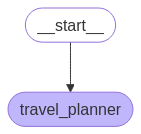

In [36]:
from IPython.display import Image, display

display(Image(travel_planner_agent.get_graph().draw_mermaid_png()))

In [37]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4", "user_id": 193}}

input_message = HumanMessage(
    content="Suggest me a good vacation destination."
)
for event in travel_planner_agent.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest me a good vacation destination.
MEMORIES:ADD_FUNC():: memories OLD got =[Item(namespace=['memories'], key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', value={'kind': 'Triple', 'content': {'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None}}, created_at='2025-03-01T19:54:54.528448+00:00', updated_at='2025-03-01T19:54:54.528453+00:00', score=None)]::, query=Suggest me a good vacation destination.:
MEMORIES:ADD_FUNC():: memories got =[Item(namespace=['memories'], key='e61cdd0f-3650-4278-b762-02f0fe2fd6c4', value={'kind': 'Triple', 'content': {'subject': 'User', 'predicate': 'vacation', 'object': 'i like to hike in mountains in the cascades in USA', 'context': None}}, created_at='2025-03-01T19:54:54.528448+00:00', updated_at='2025-03-01T19:54:54.528453+00:00', score=None)]::, update=I like to hike in the mountains in the Cascades in t